In [16]:
# Hücre 1: Kurulum ve Kütüphaneler
%pip install -q ortools
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print('Kütüphaneler yüklendi ve OR-Tools import edildi.')

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Kütüphaneler yüklendi ve OR-Tools import edildi.


In [17]:
# Hücre 2: Aynı Veri Setini Oluştur (seed=42) - 1 depo + 15 müşteri
np.random.seed(42)
n_customers = 15
coords = np.random.randint(0, 101, size=(1 + n_customers, 2))  # 0-100 arası
ids = ['Depo'] + [f'Müşteri {i+1}' for i in range(n_customers)]
types = ['Depo'] + ['Müşteri'] * n_customers
df = pd.DataFrame({'Nokta_ID': ids, 'Tip': types, 'X': coords[:,0], 'Y': coords[:,1]})
print('Oluşan DataFrame:')
df

Oluşan DataFrame:


,Nokta_ID,Tip,X,Y
0,Depo,Depo,51,92
1,Müşteri 1,Müşteri,14,71
2,Müşteri 2,Müşteri,60,20
3,Müşteri 3,Müşteri,82,86
4,Müşteri 4,Müşteri,74,74
5,Müşteri 5,Müşteri,87,99
6,Müşteri 6,Müşteri,23,2
7,Müşteri 7,Müşteri,21,52
8,Müşteri 8,Müşteri,1,87
9,Müşteri 9,Müşteri,29,37


In [18]:
# Hücre 3: OR-Tools Modeli Hazırlama (Distance Matrix hazırlama)
# OR-Tools integer mesafeler bekler; gerçek mesafeyi korumak için 100 ile çarpıp int'e çeviriyoruz
coords_arr = df[['X','Y']].to_numpy().astype(float)
n = coords_arr.shape[0]
# Gerçek (float) mesafeyi de saklayalım
def euclidean(a, b):
    return np.linalg.norm(a - b)
dist_matrix_float = [[euclidean(coords_arr[i], coords_arr[j]) for j in range(n)] for i in range(n)]
# OR-Tools için integer distance matrix
scale = 100  # hassasiyet ölçeği
dist_matrix = [[int(round(dist_matrix_float[i][j] * scale)) for j in range(n)] for i in range(n)]

# OR-Tools Routing modelleri için manager ve model oluştur
manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 1, 0)  # tek araç, başlangıç depo index 0
routing = pywrapcp.RoutingModel(manager)

# Mesafe callback'i
def distance_callback(from_index, to_index):
    # routing içindeki index'leri gerçek düğüm index'ine çevir
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return dist_matrix[from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

print('Model hazır. Distance matrix ve callback ayarlandı.')

Model hazır. Distance matrix ve callback ayarlandı.


In [19]:
# Hücre 4: Çözücü (Solver) Çalıştırma
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
# Başlangıç stratejileri: PATH_CHEAPEST_ARC hızlı bir başlangıç sağlar
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
# Local search metaheuristic: GUIDED_LOCAL_SEARCH global optimumu aramaya yardımcı olur
search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_parameters.time_limit.seconds = 20  # zaman sınırı (s)

solution = routing.SolveWithParameters(search_parameters)
if solution:
    # Yol çıkarma
    index = routing.Start(0)
    route_nodes = []
    route_distance_int = 0
    while not routing.IsEnd(index):
        node = manager.IndexToNode(index)
        route_nodes.append(node)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance_int += routing.GetArcCostForVehicle(previous_index, index, 0)
    # son dönüşde son node'u ekle (depo)
    route_nodes.append(manager.IndexToNode(index))
    # Integer mesafeyi float mesafeye çevir
    route_distance = route_distance_int / scale
    visit_sequence = [df.loc[i, 'Nokta_ID'] for i in route_nodes]
    print('Bulunan ziyaret sırası (isim):', ' -> '.join(visit_sequence))
    print(f'Toplam mesafe (yaklaşık, scale bölünmüş): {route_distance:.2f}')
else:
    print('Çözüm bulunamadı.')

Bulunan ziyaret sırası (isim): Depo -> Müşteri 5 -> Müşteri 3 -> Müşteri 4 -> Müşteri 15 -> Müşteri 14 -> Müşteri 2 -> Müşteri 11 -> Müşteri 13 -> Müşteri 6 -> Müşteri 9 -> Müşteri 7 -> Müşteri 10 -> Müşteri 8 -> Müşteri 1 -> Müşteri 12 -> Depo
Toplam mesafe (yaklaşık, scale bölünmüş): 343.54


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


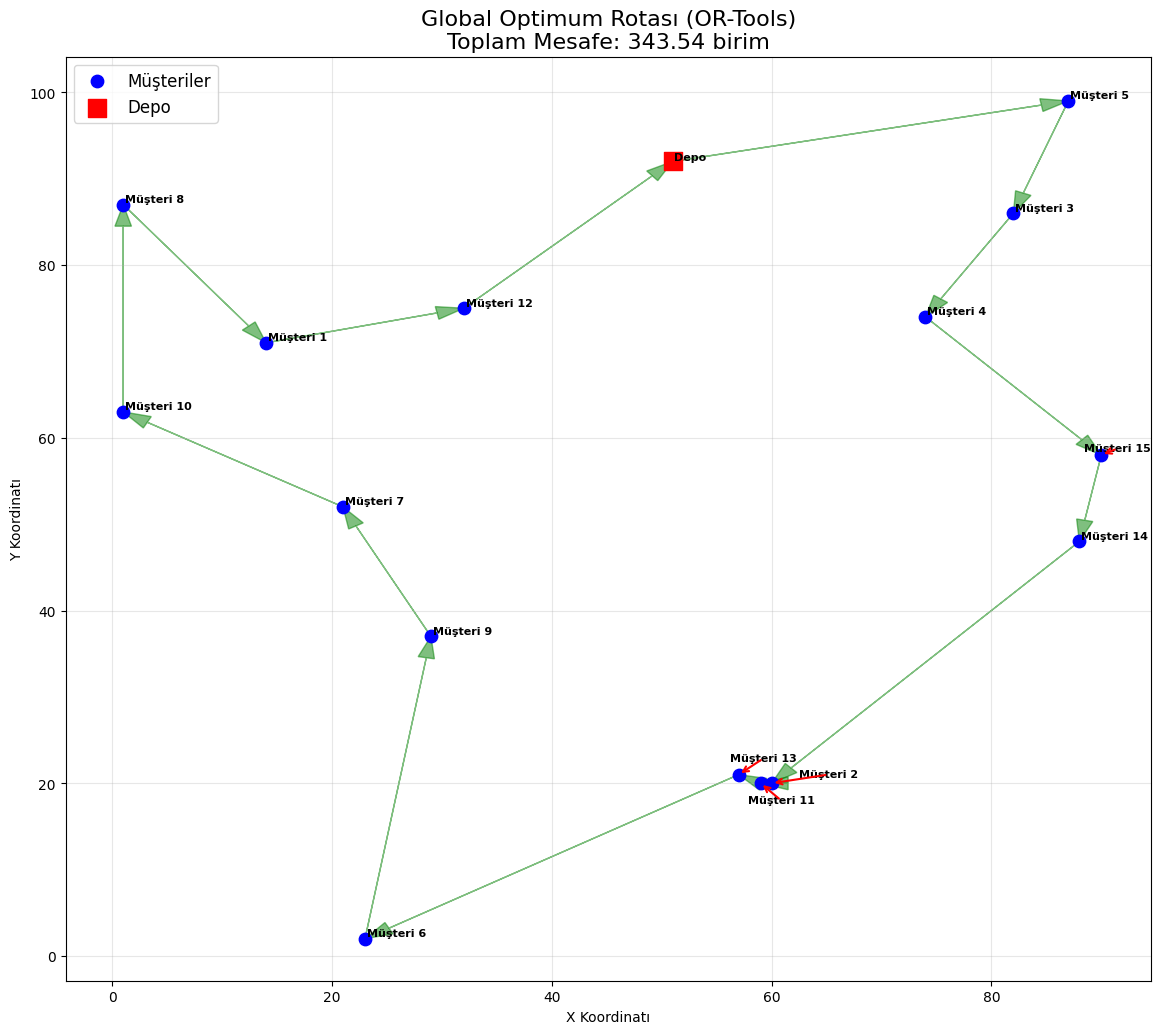

In [20]:
# Hücre 5: Sonucu Görselleştir (Gelişmiş Ayırma Ayarları ile)
# Kütüphane zaten yüklü ama garanti olsun diye kontrol ediyoruz
%pip install -q adjustText
from adjustText import adjust_text

try:
    # Eğer çözüm varsa koordinatları al
    route_coords = coords_arr[route_nodes]
    
    # Figür boyutunu biraz daha büyütelim (Ferah görünüm için)
    plt.figure(figsize=(14, 12))
    
    # 1. Müşterileri ve Depoyu Çiz
    plt.scatter(df[df['Tip']=='Müşteri']['X'], df[df['Tip']=='Müşteri']['Y'], 
                c='blue', label='Müşteriler', zorder=2, s=80) # s=nokta boyutu
    plt.scatter(df[df['Tip']=='Depo']['X'], df[df['Tip']=='Depo']['Y'], 
                c='red', marker='s', s=150, label='Depo', zorder=3)
    
    # 2. Okları Çiz (Rotayı Göster)
    for i in range(len(route_coords)-1):
        x0, y0 = route_coords[i]
        x1, y1 = route_coords[i+1]
        plt.arrow(x0, y0, x1-x0, y1-y0, length_includes_head=True, 
                  head_width=1.5, head_length=2.5, fc='green', ec='green', alpha=0.5, zorder=1)

    # 3. Agresif Etiketleme Ayarları
    texts = []
    for i in range(len(df)):
        x = df.loc[i, 'X']
        y = df.loc[i, 'Y']
        label = df.loc[i, 'Nokta_ID']
        # Fontu biraz küçült (8) ve kalın yap
        texts.append(plt.text(x, y, label, fontsize=8, fontweight='bold', color='black'))

    # SİHİRLİ KISIM BURASI: Parametreleri artırdık
    adjust_text(texts, 
                force_text=2.0,      # Yazıların birbirini itme gücü (Yüksek!)
                force_points=2.0,    # Yazıların noktadan kaçma gücü (Yüksek!)
                expand_points=(2, 2), # Nokta etrafındaki güvenli alan çarpanı
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5)) # Kılavuz okları daha belirgin (Kırmızı)
    
    plt.title(f'Global Optimum Rotası (OR-Tools)\nToplam Mesafe: {route_distance:.2f} birim', fontsize=16)
    plt.xlabel('X Koordinatı')
    plt.ylabel('Y Koordinatı')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

except NameError:
    print('HATA: Lütfen önce Hücre 4\'ü (Solver) çalıştırın.')
except Exception as e:
    print(f"Bir hata oluştu: {e}")